In [1]:
import pandas as pd 
from sqlalchemy import create_engine
import matplotlib.pyplot as plt  
import numpy as np
from scipy import stats
import math
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from scipy.stats import norm
import time
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine
import xgboost as xgb


pd.set_option('display.max_columns', 500)

### Retrieve sample data

In [2]:
import pickle
df = pickle.load(open('../back_test_sample.sav', 'rb'))
df = df.loc[df.date >= datetime.datetime(2018,1,1,0,0).timestamp()]
last_row = 0
for index, row in df.dropna().iterrows():
    ok = True
    if last_row == 0:
        last_row = row['date']
        continue
    if row['date'] - last_row  != 14400:
        print('Not consistent')
        print(row.date)
        print(last_row)
    #df.loc[df.index==index, 'dif'] = row['date'] - last_row 
    last_row = row['date']
#df[['date', 'dif']]

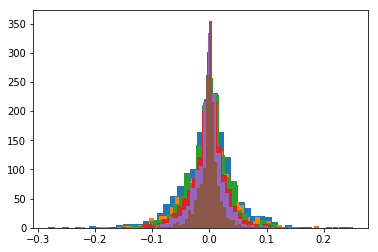

In [3]:
plt.hist(df.target_log_return_6, bins=45)
plt.hist(df.target_log_return_5, bins=45)
plt.hist(df.target_log_return_4, bins=45)
plt.hist(df.target_log_return_3, bins=45)
plt.hist(df.target_log_return_2, bins=45)
plt.hist(df.target_log_return_1, bins=45)
plt.show()

### Separate features and target variables
    - additionaly we define the probability of a non-good target hit stop loss and a good target to hit stop loss are calulated

In [4]:
def get_x_y(target_value, features_df):
    targets = ['target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',]
    
    mask = (
       ((features_df['target_log_return_1'] >= target_value)
        | (features_df['target_log_return_2'] >= target_value) 
        | (features_df['target_log_return_3'] >= target_value) 
        | (features_df['target_log_return_4'] >= target_value)
        | (features_df['target_log_return_5'] >= target_value)
        | (features_df['target_log_return_6'] >= target_value))
           )
    features_df.loc[mask, 'target_sign'] = 1
    features_df.loc[~mask, 'target_sign'] = 0
    
    drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',
              'mean_return', 'variance', 'stdev'
               ]

    # Preparing dataframe
    clean_df = features_df.drop(drop_columns, axis=1).copy()
    # Defining Features (X) and Target Variable (y)
    
    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 0][t].values)

    flat_missed_list = [item for sublist in returns for item in sublist if not math.isnan(item)]

    returns = []
    for t in targets:
        returns.append(features_df.loc[features_df['target_sign'] == 1][t].values)

    flat_list = [item for sublist in returns for item in sublist if not math.isnan(item)]
    
    
    X = clean_df.drop(['target_sign'], axis =1)
    y = clean_df[['target_sign']]
    
    return X, y, flat_missed_list, flat_list
    
    

### Running model

In [5]:
def run_model(X_sample, y_sample, target_value, threshold,  model):
    scaler = MinMaxScaler().fit(X_sample)
    X_sample = scaler.transform(X_sample)
    # Split Train, Test
    X_train, X_test = X_sample[:math.floor(len(X_sample) * 0.75)], X_sample[math.ceil(len(X_sample) * 0.75):]
    y_train, y_test = y_sample.iloc[:math.floor(len(y_sample) * 0.75)], y_sample.iloc[math.ceil(len(y_sample) * 0.75):]

    # Rebalance Samples
    oversampler = SMOTE(random_state=42)
    X_train, y_train = oversampler.fit_sample(X_train, y_train.target_sign)
    # (Re) define Models
    model.fit(X_train, y_train)
    predicted_proba = model.predict_proba(X_test)
    predicted = (predicted_proba[:, 1] >= threshold).astype('int')
    precision = precision_score(y_test, predicted)
    train_acc = accuracy_score(y_test, predicted)
    return {
        'Precision': precision,
        'Accuracy': train_acc,
        'Trades': np.sum(predicted),
        'Real Profits': np.sum(y_test)[0],
        'Target': target_value,
        'Scaler': scaler,
        'Model': model
    }

### For a given stop loss-take profit value, we define de Expected Return of the model:
    - Sum of the given values:
        - Precision of the model is right * Probability of not hitting stop loss mark * Take Profit
        - Precision of the model is right * Probability of hitting stop loss mark * Stop Loss
        - Precision of the model is wrong * Probability of not hitting stop loss mark * Mean Return of Sample
        - Precision of the model is wrong * Probability of hitting stop loss mark * Stop Loss

In [6]:
def estimate_best_stop_loss(flat_missed_list, flat_list, TP, P):
    risk_free = ((1 + 0.065) ** (1/252) - 1)
    simulations = []
    ps = 0.05
    while ps < 1:
        SL = np.percentile(flat_missed_list, ps*100)
        if SL < -3 * TP or SL > -0.01 :
            ps += 0.05
            continue
        P_stop_loss_right = len([f for f in flat_list if f <= SL])/len(flat_list)
        Mean_return_wrong = np.percentile(flat_missed_list, 5)
        ER = P * (1 - P_stop_loss_right) * TP + P * P_stop_loss_right * SL + (1 - P) * (1 - ps) * Mean_return_wrong  + (1 - P) * ps * SL
        simulations.append({
            'ER': ER,
            'Probability Stop Loss Miss': ps,
            'Probability Stop Loss Right': P_stop_loss_right,
            'Stop_Loss': SL,
            'Multiple': ER/risk_free,
            'Precision': P,
            'Take_profit': TP
        })
        ps += 0.05
    return sorted(simulations, key = lambda i: i['ER'], reverse=True)[0]
    

### For a given Size of Sample to use in model each step we do the following:
     - Run the model (if enough sample)
     - Select best parameters (Stop Loss and Take Profit)
     - Predict (if Model is good enough)
    

In [7]:
training_window = 90 # days
sample_model = training_window * (86400/14400)
target_values = [0.010, 0.015, 0.020, 0.025]
threshold = 0.8
risk_free = ((1 + 0.065) ** (1/252) - 1)

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Extra Tree': ExtraTreesClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boost': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=200,
                        objective= "binary:logistic", eval_metric="logloss", gamma=0.,  #map
                        max_delta_step=0., subsample=0.9, colsample_bytree=0.9,
                        seed=0)  
}
drop_columns = ['coin', 'date', 'period', 
                'high', 'low', 'open', 'close', 'volume', 'quote_volume',
                'weightedAverage',
                'BBUpper', 'BBLower', 'BBMiddle',
                'EMA9', 'EMA12', 'EMA26', 'EMA50',
                'SMA9', 'SMA12', 'SMA26', 'SMA50',
                'target_log_return_1', 'target_log_return_2', 'target_log_return_3',
                'target_log_return_4', 'target_log_return_5', 'target_log_return_6',
              'mean_return', 'variance', 'stdev'
               ]


back_test = df.copy()
for index, row in back_test.iterrows():
    signal = 0
    current_date = row['date']
    base_date = current_date - training_window * 6 * 14400
    model_sample = back_test.loc[(back_test.date >= base_date) & (back_test.date < current_date)].copy()
    if len(model_sample) < sample_model:
        continue
    
    best_model = {'ER': risk_free, 'Model': None}
    for target_value in target_values:
        X, y, flat_missed_list, flat_list = get_x_y(target_value, model_sample)
        model = run_model(X, y, target_value, threshold, models['XGBoost'])
        df.loc[df.date == current_date, 'Model_Precision'] = model['Precision']
        if model['Precision'] < 0.5:
            continue
        best_parameters_model = estimate_best_stop_loss(flat_missed_list, flat_list, target_value, model['Precision'])
        if best_parameters_model['ER'] > best_model['ER']:
            best_model = {
                'Model': model,
                'ER': best_parameters_model['ER'],
                'Best_parameters': best_parameters_model
            }
        
    if best_model['Model'] and best_model['ER'] > risk_free: 
        X = row.drop(drop_columns)
        X = best_model['Model']['Scaler'].transform(X.ravel().reshape(1, -1))
        predicted_proba = best_model['Model']['Model'].predict_proba(X)
        if predicted_proba[0][1] > threshold:
            signal = 1
        df.loc[df.date == current_date, 'Model_ER'] = best_model['Best_parameters']['ER']
        df.loc[df.date == current_date, 'Model_TP'] = best_model['Best_parameters']['Take_profit']
        df.loc[df.date == current_date, 'Model_SL'] = best_model['Best_parameters']['Stop_Loss']
        df.loc[df.date == current_date, 'Signal'] = signal
        df.loc[df.date == current_date, 'Precision'] = best_model['Model']['Precision']

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set

/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/macbookpro/anaconda2/envs/cryptocurrency-analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [8]:
has_balance = True
book = pd.DataFrame(columns=['date', 'coin', 'value'])
orders = pd.DataFrame(columns=['date', 'coin', 'quote', 'volume', 
                               'take_profit', 'stop_loss', 'status', 'exit', 'exit_quote'])
book.loc[len(book)] = [df.iloc[0].date,'USDT', 100]
book.loc[len(book)] = [df.iloc[0].date,'BTC', 0]


for index, row in df.iterrows():
    balance_usdt = book.loc[book['coin'] == 'USDT'].value.sum()
    balance_btc = book.loc[book['coin'] == 'BTC'].value.sum()
    open_transactions = orders.loc[(orders['status'] == 'open')]
    
    for it, rt in open_transactions.iterrows():
        if row['close'] <= rt['stop_loss']: # SELL
            book.loc[len(book)] = [row.date,'USDT', rt['volume'] * row['close']]
            book.loc[len(book)] = [row.date,'BTC', -rt['volume']]
            orders.loc[orders.index==it, 'status'] = 'close'
            orders.loc[orders.index==it, 'exit'] = np.log(row['close']/rt['quote'])
            orders.loc[orders.index==it, 'exit_quote'] = row['close']
            
        elif row['close'] >= rt['take_profit']: # SELL
            book.loc[len(book)] = [row.date,'USDT', rt['volume'] * row['close']]
            book.loc[len(book)] = [row.date,'BTC', -rt['volume']]
            orders.loc[orders.index==it, 'status'] = 'close'
            orders.loc[orders.index==it, 'exit'] = np.log(row['close']/rt['quote'])
            orders.loc[orders.index==it, 'exit_quote'] = row['close']
            
    
    if row['Signal'] == 1:
        balance_usdt = book.loc[book['coin'] == 'USDT'].value.sum()
        if balance_usdt > 0: # CAN BUY
            size_coin = (balance_usdt/row['close'])
            orders.loc[len(orders)] = [row['date'], 'BTC', row['close'], size_coin,
                                       row['Model_TP'], row['Model_SL'], 'open', 0, np.nan]
            book.loc[len(book)] = [row.date,'USDT', -balance_usdt]
            book.loc[len(book)] = [row.date,'BTC', size_coin]
    
            
        

In [9]:
book.groupby(['coin']).sum()[['value']]

value
coin           
BTC     0.00000
USDT  110.64833

In [10]:
orders['date'] = pd.to_datetime(orders['date'],unit='s')
orders

date coin        quote    volume  take_profit  stop_loss  \
0  2018-05-12 04:00:00  BTC  8321.030000  0.012018        0.015  -0.044518   
1  2018-05-12 12:00:00  BTC  8339.790000  0.012306        0.025  -0.010455   
2  2018-06-18 16:00:00  BTC  6699.368702  0.015568        0.015  -0.010486   
3  2018-06-25 04:00:00  BTC  6149.010000  0.016999        0.015  -0.012468   
4  2018-06-25 20:00:00  BTC  6240.000002  0.016966        0.015  -0.012324   
5  2018-06-26 00:00:00  BTC  6239.104890  0.016966        0.020  -0.012629   
6  2018-08-02 08:00:00  BTC  7562.779063  0.013942        0.010  -0.011140   
7  2018-08-02 16:00:00  BTC  7538.212465  0.013913        0.010  -0.011171   
8  2018-08-03 04:00:00  BTC  7401.000000  0.014168        0.010  -0.011273   
9  2018-08-14 00:00:00  BTC  5978.758046  0.017448        0.025  -0.050991   
10 2018-08-20 04:00:00  BTC  6464.048320  0.016276        0.020  -0.010990   
11 2018-08-20 16:00:00  BTC  6447.390000  0.016285        0.020  -0.010808   
12 2018-08-21 00:00:00  BTC  6306.699430  0.016139        0.020  -0.010668   
13 2018-08-21 04:00:00  BTC  6395.000000  0.016139        0.020  -0.010485   
14 2018-08-21 12:00:00  BTC  6416.138612  0.016198        0.020  -0.010373   
15 2018-08-21 16:00:00  BTC  6429.242488  0.016198        0.020  -0.010311   
16 2018-08-21 20:00:00  BTC  6468.943240  0.016198        0.020  -0.010311   
17 2018-08-26 04:00:00  BTC  6637.022244  0.016413        0.020  -0.052945   
18 2018-08-28 08:00:00  BTC  7033.059900  0.015621        0.025  -0.050937   
19 2018-08-28 12:00:00  BTC  7057.584379  0.015621        0.020  -0.012349   
20 2018-08-28 20:00:00  BTC  7076.191190  0.015676        0.020  -0.012344   
21 2018-08-29 00:00:00  BTC  7033.346769  0.015676        0.015  -0.011282   

   status         exit   exit_quote  
0   close     0.025975  8539.999999  
1   close    0.0160536  8474.753969  
2   close    0.0022539  6714.485415  
3   close    0.0127642  6228.000000  
4   close -0.000143458  6239.104890  
5   close  -0.00393536  6214.600000  
6   close  -0.00533482  7522.540452  
7   close -0.000179248  7536.861375  
8   close  -0.00520883  7362.549675  
9   close   0.00853415  6030.000000  
10  close  -0.00202219  6450.990000  
11  close   -0.0310939  6250.000000  
12  close     0.013904  6395.000000  
13  close   0.00699339  6439.879490  
14  close   0.00204025  6429.242488  
15  close   0.00615604  6468.943240  
16  close    0.0388192  6725.000000  
17  close   0.00847281  6693.495400  
18  close   0.00348096  7057.584379  
19  close   0.00616376  7101.220000  
20  close  -0.00607313  7033.346769  
21  close   0.00356666  7058.477104

In [11]:
book['date'] = pd.to_datetime(book['date'],unit='s')
book

date  coin      value
0  2018-01-01 04:00:00  USDT        100
1  2018-01-01 04:00:00   BTC          0
2  2018-05-12 04:00:00  USDT       -100
3  2018-05-12 04:00:00   BTC  0.0120177
4  2018-05-12 08:00:00  USDT    102.632
5  2018-05-12 08:00:00   BTC -0.0120177
6  2018-05-12 12:00:00  USDT   -102.632
7  2018-05-12 12:00:00   BTC  0.0123062
8  2018-05-12 16:00:00  USDT    104.292
9  2018-05-12 16:00:00   BTC -0.0123062
10 2018-06-18 16:00:00  USDT   -104.292
11 2018-06-18 16:00:00   BTC  0.0155675
12 2018-06-18 20:00:00  USDT    104.528
13 2018-06-18 20:00:00   BTC -0.0155675
14 2018-06-25 04:00:00  USDT   -104.528
15 2018-06-25 04:00:00   BTC  0.0169991
16 2018-06-25 08:00:00  USDT    105.871
17 2018-06-25 08:00:00   BTC -0.0169991
18 2018-06-25 20:00:00  USDT   -105.871
19 2018-06-25 20:00:00   BTC  0.0169664
20 2018-06-26 00:00:00  USDT    105.855
21 2018-06-26 00:00:00   BTC -0.0169664
22 2018-06-26 00:00:00  USDT   -105.855
23 2018-06-26 00:00:00   BTC  0.0169664
24 2018-06-26 04:00:00  USDT     105.44
25 2018-06-26 04:00:00   BTC -0.0169664
26 2018-08-02 08:00:00  USDT    -105.44
27 2018-08-02 08:00:00   BTC  0.0139419
28 2018-08-02 12:00:00  USDT    104.879
29 2018-08-02 12:00:00   BTC -0.0139419
..                 ...   ...        ...
60 2018-08-21 16:00:00  USDT    104.144
61 2018-08-21 16:00:00   BTC -0.0161984
62 2018-08-21 16:00:00  USDT   -104.144
63 2018-08-21 16:00:00   BTC  0.0161984
64 2018-08-21 20:00:00  USDT    104.787
65 2018-08-21 20:00:00   BTC -0.0161984
66 2018-08-21 20:00:00  USDT   -104.787
67 2018-08-21 20:00:00   BTC  0.0161984
68 2018-08-22 00:00:00  USDT    108.934
69 2018-08-22 00:00:00   BTC -0.0161984
70 2018-08-26 04:00:00  USDT   -108.934
71 2018-08-26 04:00:00   BTC  0.0164131
72 2018-08-26 08:00:00  USDT    109.861
73 2018-08-26 08:00:00   BTC -0.0164131
74 2018-08-28 08:00:00  USDT   -109.861
75 2018-08-28 08:00:00   BTC  0.0156207
76 2018-08-28 12:00:00  USDT    110.244
77 2018-08-28 12:00:00   BTC -0.0156207
78 2018-08-28 12:00:00  USDT   -110.244
79 2018-08-28 12:00:00   BTC  0.0156207
80 2018-08-28 16:00:00  USDT    110.926
81 2018-08-28 16:00:00   BTC -0.0156207
82 2018-08-28 20:00:00  USDT   -110.926
83 2018-08-28 20:00:00   BTC  0.0156759
84 2018-08-29 00:00:00  USDT    110.254
85 2018-08-29 00:00:00   BTC -0.0156759
86 2018-08-29 00:00:00  USDT   -110.254
87 2018-08-29 00:00:00   BTC  0.0156759
88 2018-08-29 04:00:00  USDT    110.648
89 2018-08-29 04:00:00   BTC -0.0156759

[90 rows x 3 columns]

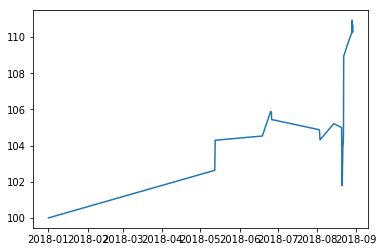

In [12]:
coin_book = book.loc[(book['coin'] == 'USDT') & (book['value'] >= 0 )]
plt.plot(coin_book['date'], coin_book['value'])
plt.show()

In [13]:
dif = ((datetime.datetime.fromtimestamp(df.iloc[-1].date) - datetime.datetime(2018,1,1)).days)

In [14]:
risk_free = ((1 + 0.065) ** (1/252) - 1)

In [15]:
risk_free

0.00024993122427763304

In [16]:
return_dif =  (book.loc[book['coin'] == 'USDT'].groupby(['coin']).sum()[['value']].values[0][0]/100 - 1)

In [17]:
((1 + return_dif) ** (365/dif) - 1)

0.1513858788334035

In [18]:
0.065

0.065